In [1]:
import osmnx as ox
import pandana
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Download and prep network

In [6]:
# Select place and crs
place = 'Guelph, Canada'
crs = 3978

In [7]:
# Download the street network
G = ox.graph_from_place(place, network_type="walk")

# Project the network
G = ox.projection.project_graph(G, to_crs=crs)

In [36]:
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed in km/h
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in G.edges(data=True):
    data['speed_kph'] = walk_speed
G = ox.add_edge_travel_times(G)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(G, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G, nodes=False).reset_index()[['u', 'v', 'travel_time']]

## Gather points of interest (POIs)

In [49]:
# Select points of interest based on osm tags
tags = {
    'shop':[
        'supermarket'
    ]
}

# Get amentities from place
pois = ox.geometries.geometries_from_place(place, tags=tags)

# Project pois
pois = pois.to_crs(epsg=crs)

In [51]:
# Load two sample pois and simplify dataframe for examination
sample_rate = 2
pois_sample = pois.sample(sample_rate)
pois_sample["lat"] = pois_sample['geometry'].y
pois_sample["lon"] = pois_sample['geometry'].x
pois_sample = pois_sample[['name', 'lat', 'lon']]
pois_sample

name            lat           lon
element_type osmid                                               
node         1357939651    No Frills -474182.593382  1.213397e+06
             1357939643  Food Basics -476374.311577  1.216507e+06

## Build pandanas network

In [52]:
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

Formally add the pois into the network

In [53]:
# Extract centroids from the pois' geometries
centroids = pois.centroid

# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the pois' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
)

c:\Users\Shane\miniconda3\envs\geo\lib\site-packages\pandana\network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
c:\Users\Shane\miniconda3\envs\geo\lib\site-packages\pandana\network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Now get the distances (in meters) and IDs of a specified number of closest pois to each network node

In [54]:
# Specify the number of pois' to analyse distance to
num_pois = 10

# calculate travel time to 10 nearest pois from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=num_pois
)

# Show distances (in meters) and IDs of the specified closest pois to each network node
distances.astype(int).head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
33082348,900,900,900,900,900,900,900,900,900,900
2265511730,900,900,900,900,900,900,900,900,900,900
33082359,900,900,900,900,900,900,900,900,900,900
33083776,900,900,900,900,900,900,900,900,900,900
33082364,900,900,900,900,900,900,900,900,900,900


In [76]:
distances.describe()

,1,2,3,4,5,6,7,8,9,10
count,25540.000000,25540.000000,25540.000000,25540.000000,25540.000000,25540.000000,25540.000000,25540.0,25540.0,25540.0
mean,710.873267,810.430289,846.533485,872.906098,888.465535,896.424782,897.879255,900.0,900.0,900.0
std,259.277054,188.495023,144.631195,101.710528,61.262607,32.743669,24.017838,0.0,0.0,0.0
min,0.000000,21.700001,107.800003,144.699997,305.200012,422.000000,475.500000,900.0,900.0,900.0
25%,543.074249,863.274994,900.000000,900.000000,900.000000,900.000000,900.000000,900.0,900.0,900.0
50%,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.0,900.0,900.0
75%,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.0,900.0,900.0
max,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.0,900.0,900.0


## Plot results

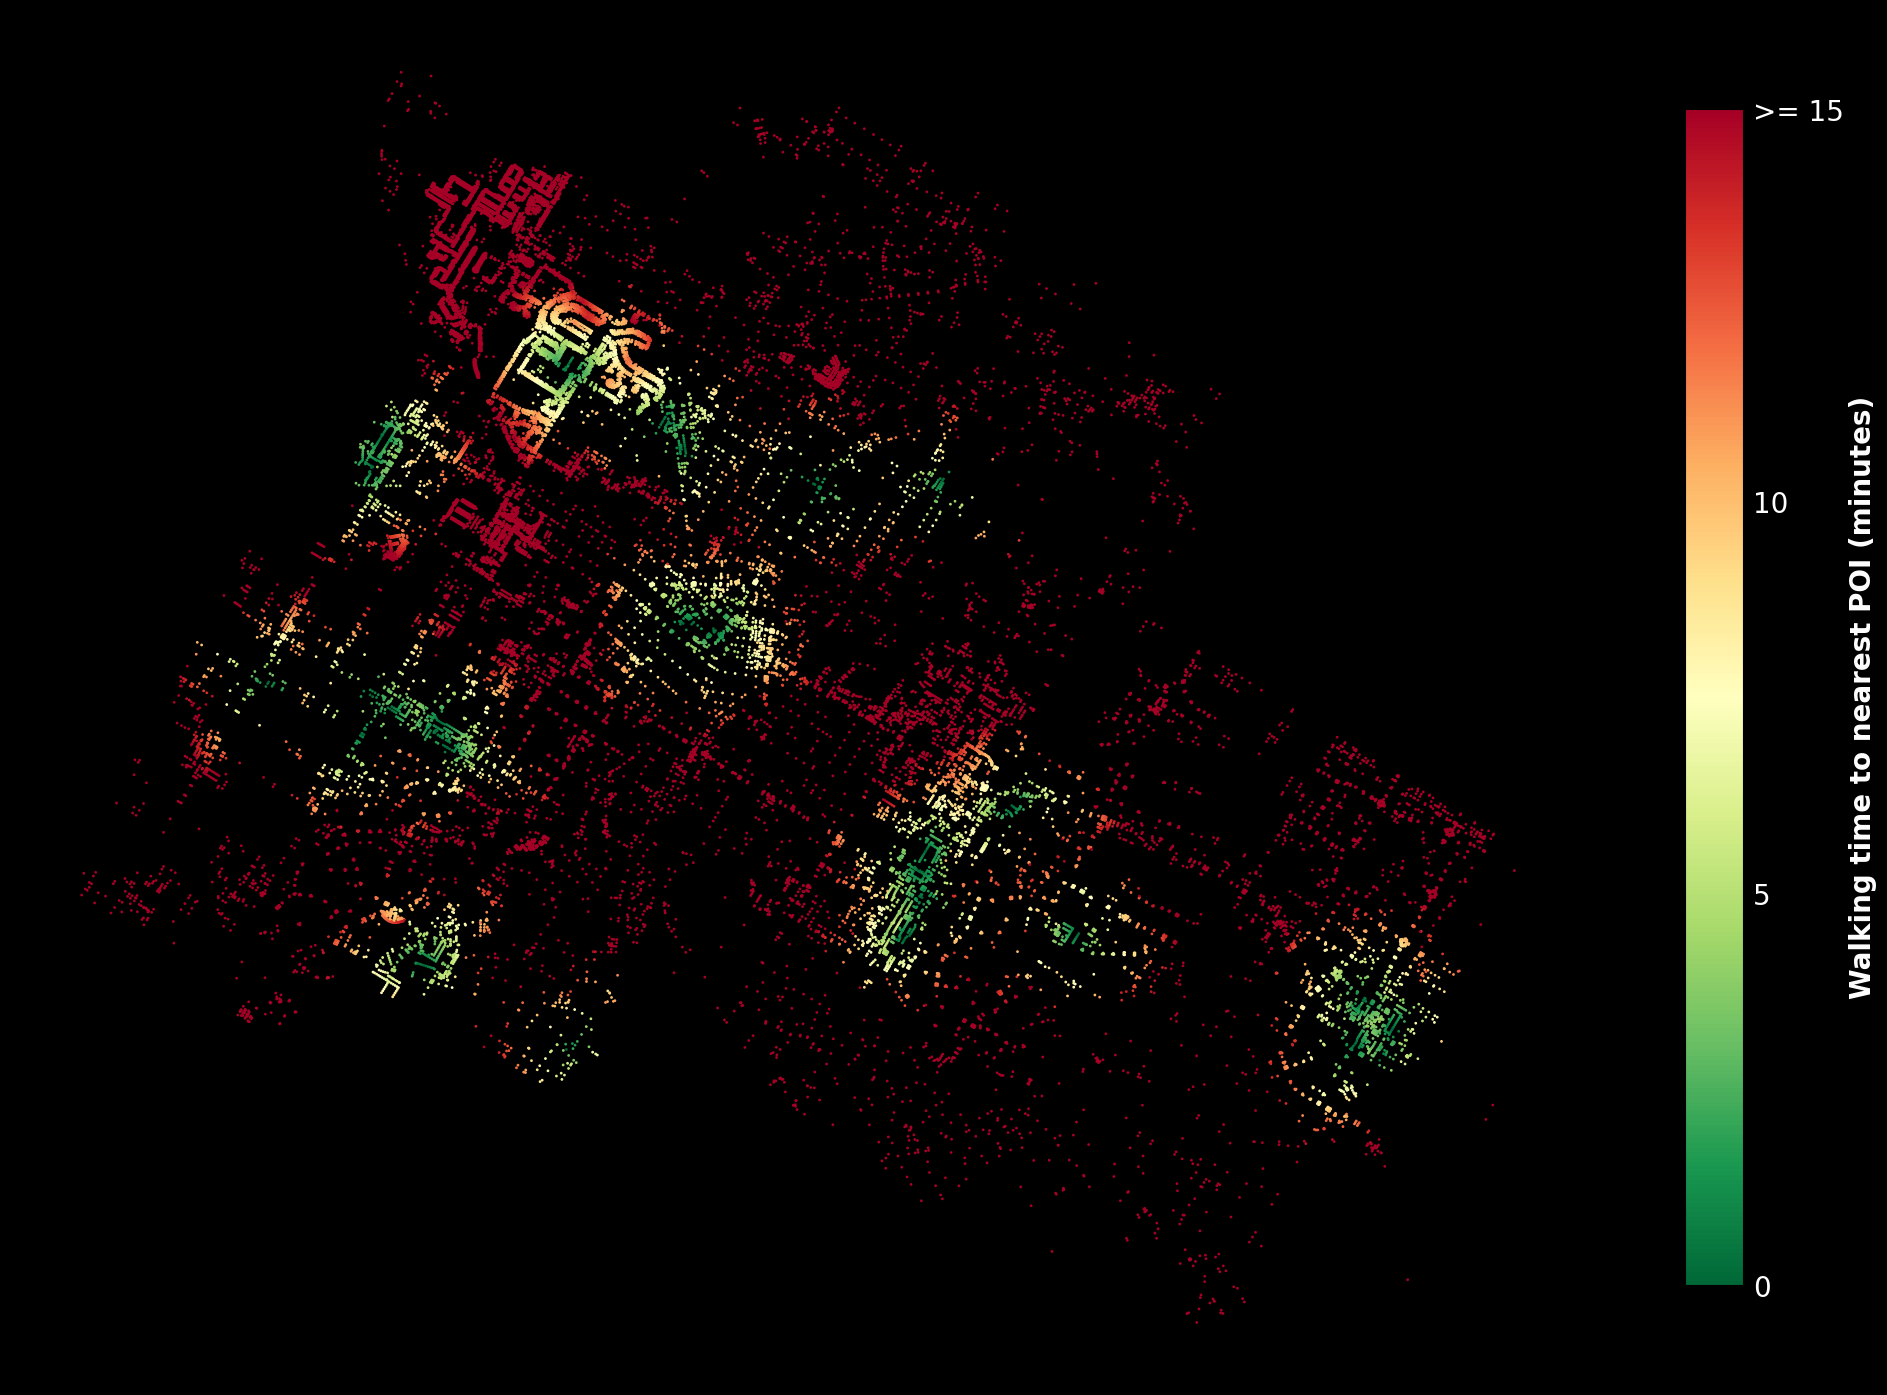

In [69]:
# Set text parameters
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Set colormap 
#cmap = 'viridis_r'
cmap = 'RdYlGn_r'

# Plot distance to nearest POI
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[1],
    s=1,
    cmap=cmap,
)

# Colorbar
cb = fig.colorbar(sc, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
cb.set_label('Walking time to nearest POI (minutes)', fontsize=20, fontweight='bold')

# Remove empty space
plt.tight_layout()

# Save
plt.savefig('./docs/walk_access.png')

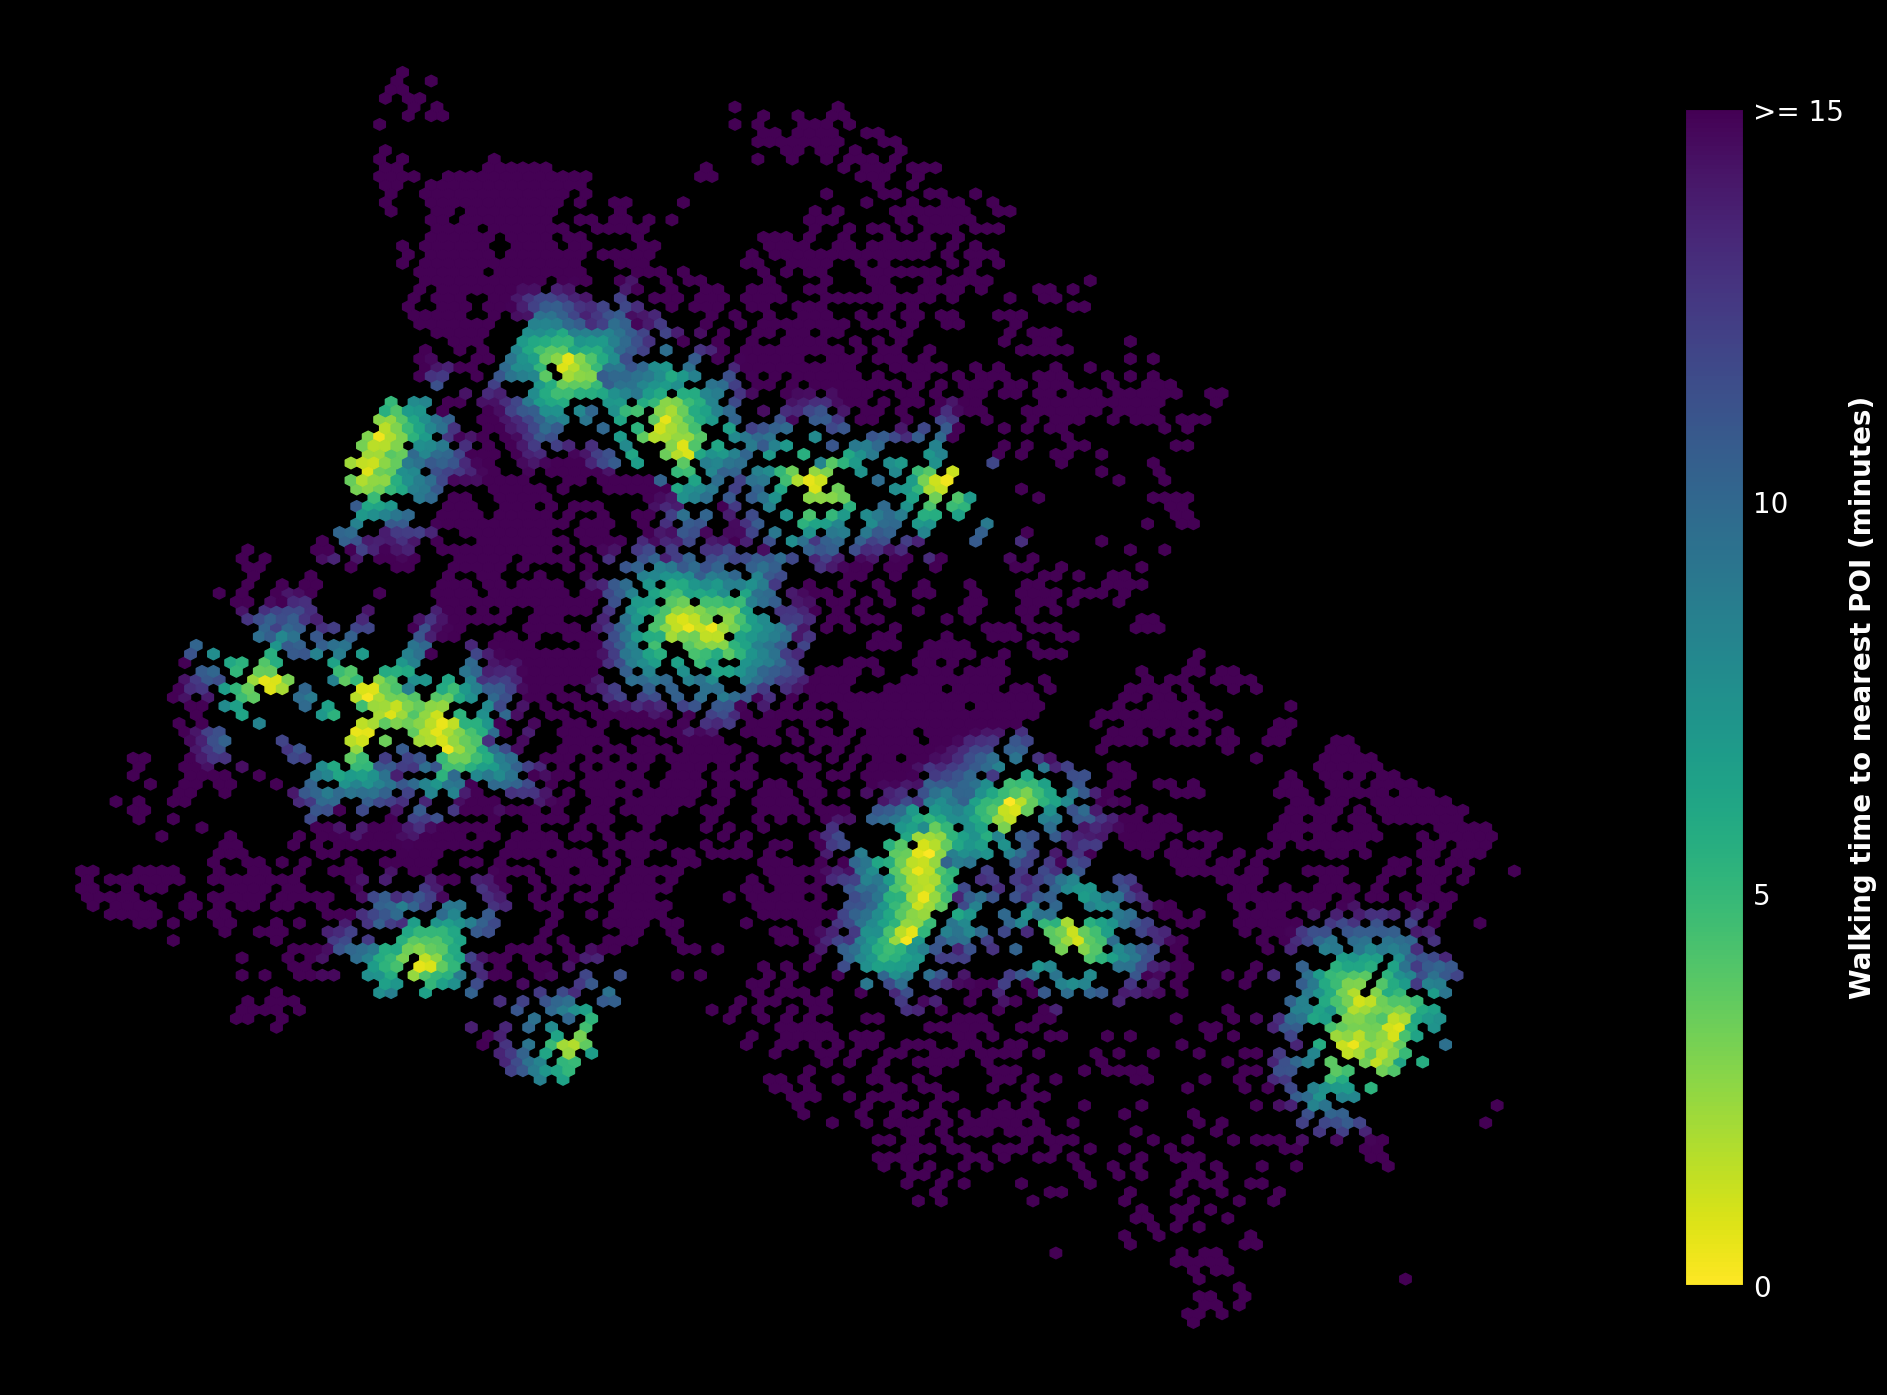

In [70]:
# Set text parameters
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Set colormap 
cmap = 'viridis_r'
#cmap = 'RdYlGn_r'
#cmap = 'plasma_r'

# Plot distance to nearest POI
hb = ax.hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=125,
    cmap=cmap,
    C=distances[1],
    alpha=1
)
sc
# Colorbar
cb = fig.colorbar(hb, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
cb.set_label('Walking time to nearest POI (minutes)', fontsize=20, fontweight='bold')

# Remove empty space
plt.tight_layout()

# Save
plt.savefig('./docs/walk_access_hb.png')

In [72]:
# Get nodes with wgs coords for output csv
graph_wgs = ox.projection.project_graph(G, to_crs=3978)
nodes_wgs = ox.graph_to_gdfs(graph_wgs, edges=False)[['x', 'y']]

In [73]:
# Join travel time info to nodes
walk_access = nodes.join(distances, on='osmid', how='left')
walk_access_wgs = nodes_wgs.join(distances, on='osmid', how='left')

In [74]:
walk_access_wgs.head()

,x,y,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,,,
33082348,1.210427e+06,-474746.844381,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
2265511730,1.210032e+06,-474780.406649,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
387533115,1.209890e+06,-474799.436327,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
2447411616,1.209840e+06,-474987.866833,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
33082359,1.210490e+06,-474728.728809,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0


In [75]:
# Save as CSV
walk_access_wgs.to_csv('./data/walk_access.csv', encoding='utf-8')